# RBMs for feature extraction and for weight initialization in a Deep Belief Network

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense

In [110]:
# Load saved mnist data
# These are readily available and can be downloaded

trainx = np.load("data/mnist_train.npy")
trainy = np.load("data/mnist_trainy.npy")

# Convert labels to binary since we will use a softmax output
trainy = np.argmax(trainy,axis=1)
data = trainx

## We will first train a simple Logistic Regrassion model that will serve as a baseline

In [37]:
logreg = linear_model.LogisticRegression(C=1.0)

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(trainx,trainy)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
# Load Test data 

testx = np.load("data/mnist_test.npy")
testy = np.load("data/mnist_testy.npy")
testy = np.argmax(testy,axis=1)

print(classification_report(testy, logreg.predict(testx)))

             precision    recall  f1-score   support

          0       0.95      0.98      0.96       980
          1       0.96      0.98      0.97      1135
          2       0.94      0.89      0.91      1032
          3       0.90      0.91      0.90      1010
          4       0.92      0.93      0.92       982
          5       0.89      0.86      0.88       892
          6       0.94      0.95      0.94       958
          7       0.93      0.92      0.93      1028
          8       0.88      0.87      0.87       974
          9       0.90      0.89      0.90      1009

avg / total       0.92      0.92      0.92     10000



## We will now train an RBM to learn Latent Features

In [7]:
from sklearn.neural_network import BernoulliRBM
# The RBM will have 200 hidden units and will run for 40 iterations with CD-1
rbm = BernoulliRBM(n_components = 200, n_iter = 40,learning_rate = 0.01,  verbose = True)

rbm.fit(data)

# Save the weights of the visible and hidden connections
np.save("rbm_weights.npy",rbm.components_)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -101.24, time = 42.31s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -89.12, time = 51.06s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -84.91, time = 47.59s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -78.25, time = 47.77s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -77.10, time = 50.87s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -73.62, time = 49.70s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -75.44, time = 52.70s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -74.79, time = 51.19s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -72.15, time = 51.67s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -69.50, time = 48.74s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -70.39, time = 56.51s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -69.70, time = 50.10s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -70.68, time = 51.69s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -69.61, time = 55.10s
[BernoulliRBM]

In [28]:
W = np.load("rbm_weights.npy")

W.shape

(200, 784)

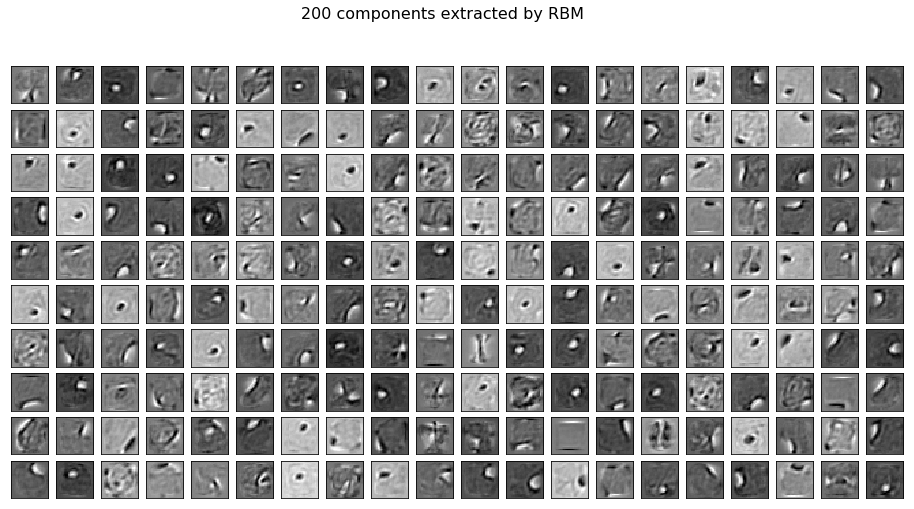

In [24]:
%matplotlib inline
weightmap_shape = (28,28)
fig,axes = plt.subplots(10,20, figsize=(16,8))
fig.suptitle('200 components extracted by RBM', fontsize=16)
fig.subplots_adjust(hspace = 0.1)
for i,ax in enumerate(axes.flatten()):
    
    ax.imshow(W[i].reshape(weightmap_shape),cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])


In [8]:
# Save hidden state biases and activations
# The activations are the latent features we need
np.save("rbm_biases.npy",rbm.intercept_hidden_)
np.save("data/mnist_hidden.npy",rbm.transform(data))

## Use extracted featured to train a Logistic Regression model

In [10]:
# Run logistic regression on the transformed data, i.e the latent features

logrbm = linear_model.LogisticRegression(C=1.0)

h = rbm.transform(data)
logrbm.fit(h,trainy)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
print(classification_report(testy, logrbm.predict(rbm.transform(testx))))

             precision    recall  f1-score   support

          0       0.96      0.99      0.97       980
          1       0.98      0.99      0.99      1135
          2       0.96      0.94      0.95      1032
          3       0.94      0.95      0.95      1010
          4       0.96      0.95      0.96       982
          5       0.96      0.94      0.95       892
          6       0.97      0.97      0.97       958
          7       0.97      0.96      0.96      1028
          8       0.93      0.95      0.94       974
          9       0.95      0.94      0.94      1009

avg / total       0.96      0.96      0.96     10000



In [29]:
rbm_biases = np.load("rbm_biases.npy")
rbm_weights = np.load("rbm_weights.npy")

print(rbm_biases.shape, rbm_weights.shape)
#testh = 1/(1 + np.exp(-(np.dot(data,rbm_weights.transpose()) + rbm_biases)))

(200,) (200, 784)


In [30]:
rbm_weight = rbm_weights.T
rbm_bias = rbm_biases

In [43]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("../../notebooks/data/MNIST/", one_hot=True)
data.test.cls = np.array([label.argmax() for label in data.test.labels])

Extracting ../../notebooks/data/MNIST/train-images-idx3-ubyte.gz
Extracting ../../notebooks/data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../notebooks/data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../notebooks/data/MNIST/t10k-labels-idx1-ubyte.gz


## Build a Deep Belief Net. 
## This is nothing but a Multi Layer Perceptron intialised with trained RBM weights and biases

In [86]:
import tensorflow as tf

# variables for dimensions 
feature_size = 200
img_size = 28*28
num_classes = 10


# Input , This will be a raw image from MNIST dataset
x = tf.placeholder(tf.float32,[None, img_size])

# Placeholders for labels
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64,[None])

# Connections between input layer and first hidden layer
# These will be initialised with RBM weights and biases

rbm_w = tf.Variable(rbm_weight.astype(np.float32))
rbm_b = tf.Variable(rbm_bias.astype(np.float32))
_h = tf.nn.relu(tf.matmul(x, rbm_w) + rbm_b)


# Connections from hidden layer to final output layer
weights = tf.Variable(tf.random_normal([feature_size, num_classes],stddev=0.35))
biases = tf.Variable(tf.zeros([num_classes]))

logits = tf.matmul(_h, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.Session()

sess.run(tf.global_variables_initializer())

In [95]:
batch_size = 32
mytrainy = np.load("data/mnist_trainy.npy")
def optimize(num_iterations):
    for i in range(num_iterations):
        train_x, train_y = trainx, mytrainy
        
        feed_dict_for_training = {x:train_x,
                                  y_true: train_y}
        
        sess.run(optimizer,feed_dict=feed_dict_for_training)
        

In [96]:
feed_dict_for_testing = { x: testx,
                          y_true_cls : testy}

def get_accuracy():
    acc = sess.run(accuracy, feed_dict=feed_dict_for_testing)
    
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [97]:
get_accuracy()

Accuracy on test-set: 14.0%


In [98]:
optimize(num_iterations = 10)

In [99]:
get_accuracy()

Accuracy on test-set: 71.7%


In [100]:
optimize(num_iterations = 90)
get_accuracy()

Accuracy on test-set: 93.5%


In [102]:
optimize(num_iterations = 100)
get_accuracy()

Accuracy on test-set: 95.2%


In [103]:
optimize(num_iterations = 100)
get_accuracy()

Accuracy on test-set: 95.1%


## We will use keras which already has a lot of optimizations built in for neural networks

In [78]:
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=784, name='rbm'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# set weights between input and hidden layer and hidden biases
layer = model.get_layer('rbm')
layer.set_weights([rbm_weight,rbm_bias])


# Train the model, iterating on the data in batches of 32 samples
model.fit(trainx, trainy, epochs=10, batch_size=32)

Epoch 1/10
55000/55000 [==============================] - 8s - loss: 0.4173 - acc: 0.8985       

In [90]:
print(classification_report(testy, np.argmax(model.predict(testx),axis=1)))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98       980
          1       0.99      0.99      0.99      1135
          2       0.97      0.98      0.98      1032
          3       0.98      0.98      0.98      1010
          4       0.98      0.97      0.98       982
          5       0.98      0.97      0.98       892
          6       0.99      0.98      0.99       958
          7       0.98      0.98      0.98      1028
          8       0.95      0.98      0.97       974
          9       0.97      0.97      0.97      1009

avg / total       0.98      0.98      0.98     10000



## What if we directly trained a MLP ?

In [132]:
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=784))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Generate dummy data
# Train the model, iterating on the data in batches of 32 samples
model.fit(trainx, mytrainy, epochs=10, batch_size=32)

Epoch 1/10
55000/55000 [==============================] - 8s - loss: 0.2434 - acc: 0.9307        

In [133]:
print(classification_report(testy, np.argmax(model.predict(testx),axis=1)))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       980
          1       0.99      0.99      0.99      1135
          2       0.97      0.98      0.97      1032
          3       0.98      0.98      0.98      1010
          4       0.98      0.98      0.98       982
          5       0.97      0.98      0.97       892
          6       0.99      0.97      0.98       958
          7       0.98      0.98      0.98      1028
          8       0.98      0.96      0.97       974
          9       0.97      0.97      0.97      1009

avg / total       0.98      0.98      0.98     10000



## Longer training

In [134]:
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=784, name='rbm'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

layer = model.get_layer('rbm')
layer.set_weights([rbm_weights.transpose(),rbm_biases])

# Generate dummy data
# Train the model, iterating on the data in batches of 32 samples
model.fit(trainx, mytrainy, epochs=25, batch_size=32)


Epoch 1/25
55000/55000 [==============================] - 8s - loss: 0.4622 - acc: 0.8960       

In [ ]:
print(classification_report(testy, np.argmax(model.predict(testx),axis=1)))

In [112]:
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=784))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Generate dummy data
# Train the model, iterating on the data in batches of 32 samples
model.fit(trainx, mytrainy, epochs=25, batch_size=32)

Epoch 1/25
55000/55000 [==============================] - 10s - loss: 0.2476 - acc: 0.9275       